In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
# from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from kirchhoff import Kirchhoff

# MODEL, GEOM AND SOURCE DEFINITON - for now single sources

In [2]:
# Velocity Model
nx, nz = 101, 101
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Microseismic sources
xmicro = [nx//4, nx//2,  3*(nx//4), ]
zmicro = [nz//4, nz//2,  3*(nz//4), ]
ampmicro = [1,1,1]
ns = len(zmicro)

microseismic = np.zeros((ns, nx, nz))
event_dictionary = []
for ev in range(ns):
    microseismic[ev, xmicro[ev], zmicro[ev]] = ampmicro[ev]
    event_dictionary.append({'event':ev,
                             'sx':xmicro[ev],
                             'sz':zmicro[ev],
                             'amp':ampmicro[ev],
                            })

In [3]:
# Define Receiver grid as lines in X and Z
nr_z = 20
nr_x = 20
rec_string = '%i-by-%i'%(nr_x,nr_z)

rec_buffer = 2 
r_z_locs = np.linspace(rec_buffer*dz, (nz-rec_buffer)*dz, nr_z)
r_x_locs = np.linspace(rec_buffer*dx, (nx-rec_buffer)*dx, nr_x)

rx, rz = np.meshgrid(r_x_locs,r_z_locs)
recs = np.vstack((rx.flatten(), rz.flatten()))
nr = recs.shape[1]
# dr = recs[0,1]-recs[0,0]

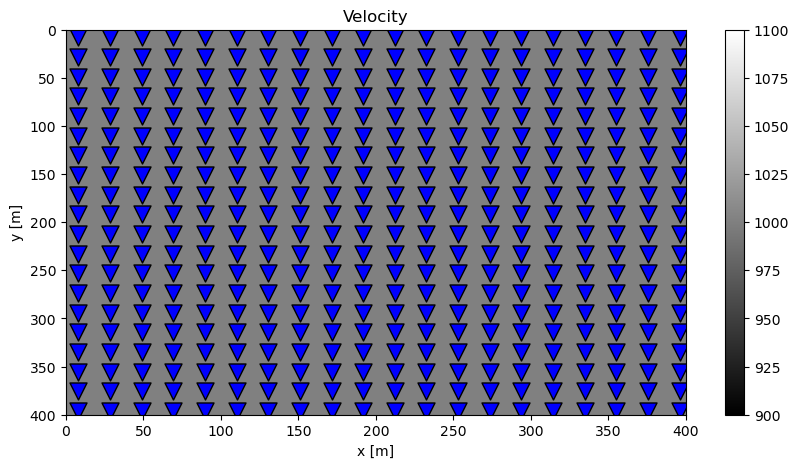

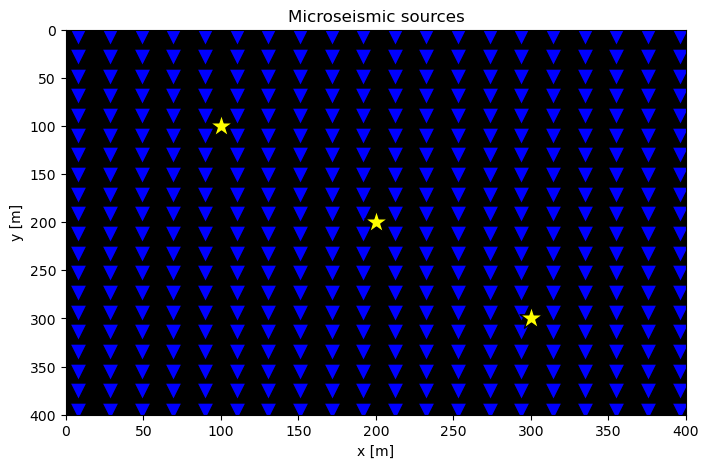

In [4]:
plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(8,5))
im = plt.imshow(microseismic.T, cmap='binary', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[xmicro], z[zmicro], marker='*', s=300, c='yellow', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Microseismic sources')
plt.xlim(x[0], x[-1]);

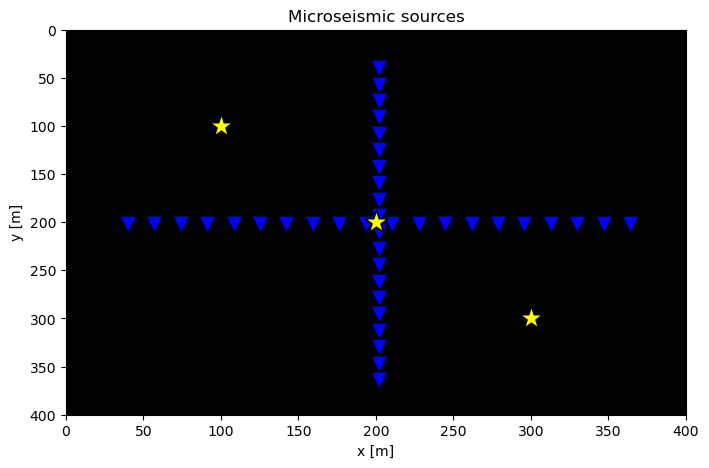

In [5]:
# Cross-Array
rIL_z_locs = np.linspace(10*dz, (nz-10)*dz, nr_z)
rIL_x_locs = np.mean(r_x_locs)
rILx, rILz = np.meshgrid(rIL_x_locs,rIL_z_locs)
recsIL = np.vstack((rILx.flatten(), rILz.flatten()))
nrIL = recsIL.shape[1]

rXL_z_locs = np.mean(r_z_locs)
rXL_x_locs = np.linspace(10*dx, (nx-10)*dx, nr_x)
rXLx, rXLz = np.meshgrid(rXL_x_locs,rXL_z_locs)
recsXL = np.vstack((rXLx.flatten(), rXLz.flatten()))
nrXL = recsXL.shape[1]

recs_X = np.vstack([np.hstack((rILx.flatten(),rXLx.flatten())).flatten(),
                    np.hstack((rILz.flatten(),rXLz.flatten())).flatten(),
                   ])

plt.figure(figsize=(8,5))
im = plt.imshow(microseismic.T, cmap='binary', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs_X[0],  recs_X[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[xmicro], z[zmicro], marker='*', s=300, c='yellow', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Microseismic sources')
plt.xlim(x[0], x[-1]);

# MAKE DATA

In [6]:
trav = Kirchhoff._traveltime_table(z, x, recs, recs, v0, mode='analytic')[1] #for modelling

In [7]:
nt = 451
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, nr)
travd = travd.reshape(nx, nz, nr)

In [8]:
# INITIALISE OPERATOR
Op = Kirchhoff(z, x, t, recs[:, :1], recs, v0, wav, wavc, mode='analytic', engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=1524.5697348336776 - u^H(Op^Hv)=1524.5697348336737


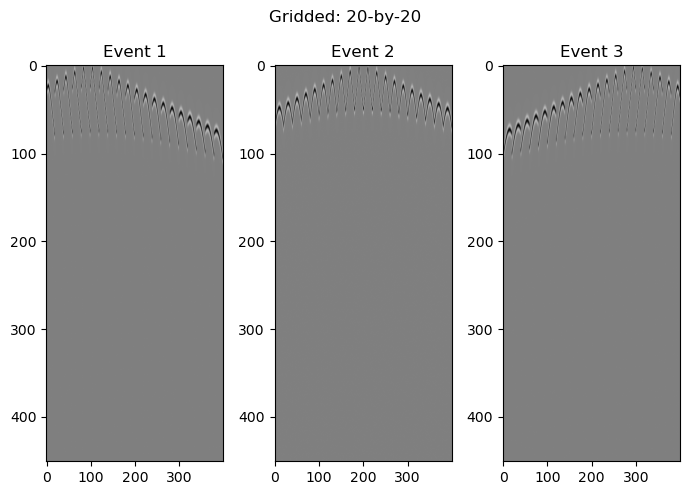

In [9]:
# PERFORM FORWARD (MODEL)
leftEv_fulldata = Op @ microseismic[0].squeeze()
midEv_fulldata = Op @ microseismic[1].squeeze()
rightEv_fulldata = Op @ microseismic[2].squeeze()

fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(leftEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(midEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(rightEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Event 1')
axs[1].set_title('Event 2')
axs[2].set_title('Event 3')
plt.suptitle('Gridded: %s'%rec_string)
plt.tight_layout()

In [10]:
# PERFORM ADJOINT (MIGRATE)
mig_Ev1 = Op.H @ leftEv_fulldata
mig_Ev2 = Op.H @ midEv_fulldata
mig_Ev3 = Op.H @ rightEv_fulldata

# PERFORM LSQR
minv_Ev1 = lsqr(Op, leftEv_fulldata.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev2 = lsqr(Op, midEv_fulldata.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev3 = lsqr(Op, rightEv_fulldata.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 180400 rows and 10201 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.776e+01  3.776e+01    1.0e+00  4.9e+00
     1  5.27879e-05   1.785e+01  1.785e+01    4.7e-01  7.1e-01   2.1e+02  1.0e+00
     2  2.19411e-04   1.185e+01  1.185e+01    3.1e-01  4.0e-01   3.0e+02  2.2e+00
     3  4.47263e-04   8.395e+00  8.395e+00    2.2e-01  2.9e-01   3.6e+02  3.6e+00
     4  1.02095e-03   6.645e+00  6.645e+00    1.8e-01  2.0e-01   4.2e+02  5.0e+00
     5 -4.54123e-05   5.530e+00  5.530e+00    1.5e-01  1.8e-01   4.6e+02  6.7e+00
     6 -1.15442e-03   4.505e+00  4.505e+00    1.2e-01  1.4e-01   4.9e+02  8.8e+00
     7 -1.19703e-03   3.883e+00  3.883e+00    1.0e-01  1.2e-01   5.2e+02  1.1e+01
     8 -8.99879e-04   3.429e+00

In [11]:
def threeevent_invFigure(mig_list, lsqr_list, event_dictionary, inc_maximums=True, title_string=' '):
    fig, axs = plt.subplots(2,3, figsize=(17, 10))
    
    for i in range(3):
        ev_x = event_dictionary[i]['sx']
        ev_z = event_dictionary[i]['sz']
        
        axs[0][i].imshow(mig_list[i].T, cmap='gray')
        axs[0][i].scatter(ev_x, ev_z, marker='.', s=100, c='g', edgecolors='k')
        axs[0][i].set_title(r'$Event%i : m_{adj}$'%i)
        axs[1][i].imshow(lsqr_list[i].T, cmap='RdBu', 
                         vmin=-1*np.percentile(abs(lsqr_list[i]),99.9), vmax=np.percentile(abs(lsqr_list[i]),99.9))
        axs[1][i].set_title(r'$Event%i : m_{inv}$'%i)
        
        if inc_maximums:
            ev_locs = get_max_locs(lsqr_list[i], n_max=1, rem_edge=False)
            axs[1][i].scatter(ev_locs[0], ev_locs[1], marker='s', s=50, c='yellow', edgecolors='k')
            ev_locs = get_max_locs(lsqr_list[i], n_max=1)
            axs[1][i].scatter(ev_locs[0], ev_locs[1], marker='s', s=50, c='green', edgecolors='k')
    for ax in axs.ravel(): ax.axis('tight')
        
    plt.suptitle(title_string, fontsize=18)
    plt.tight_layout()


In [12]:
def get_max_locs(image, n_max=50, rem_edge=True):
    if rem_edge:
        cropped_image = image[10:-10,10:-10]
        ev_locs = np.array(np.unravel_index(np.argpartition(cropped_image.ravel(), -1*n_max)[-n_max:],
                                     cropped_image.shape))
        return ev_locs+10
        
    else:        
        return np.array(np.unravel_index(np.argpartition(image.ravel(), -1*n_max)[-n_max:],
                                     image.shape))

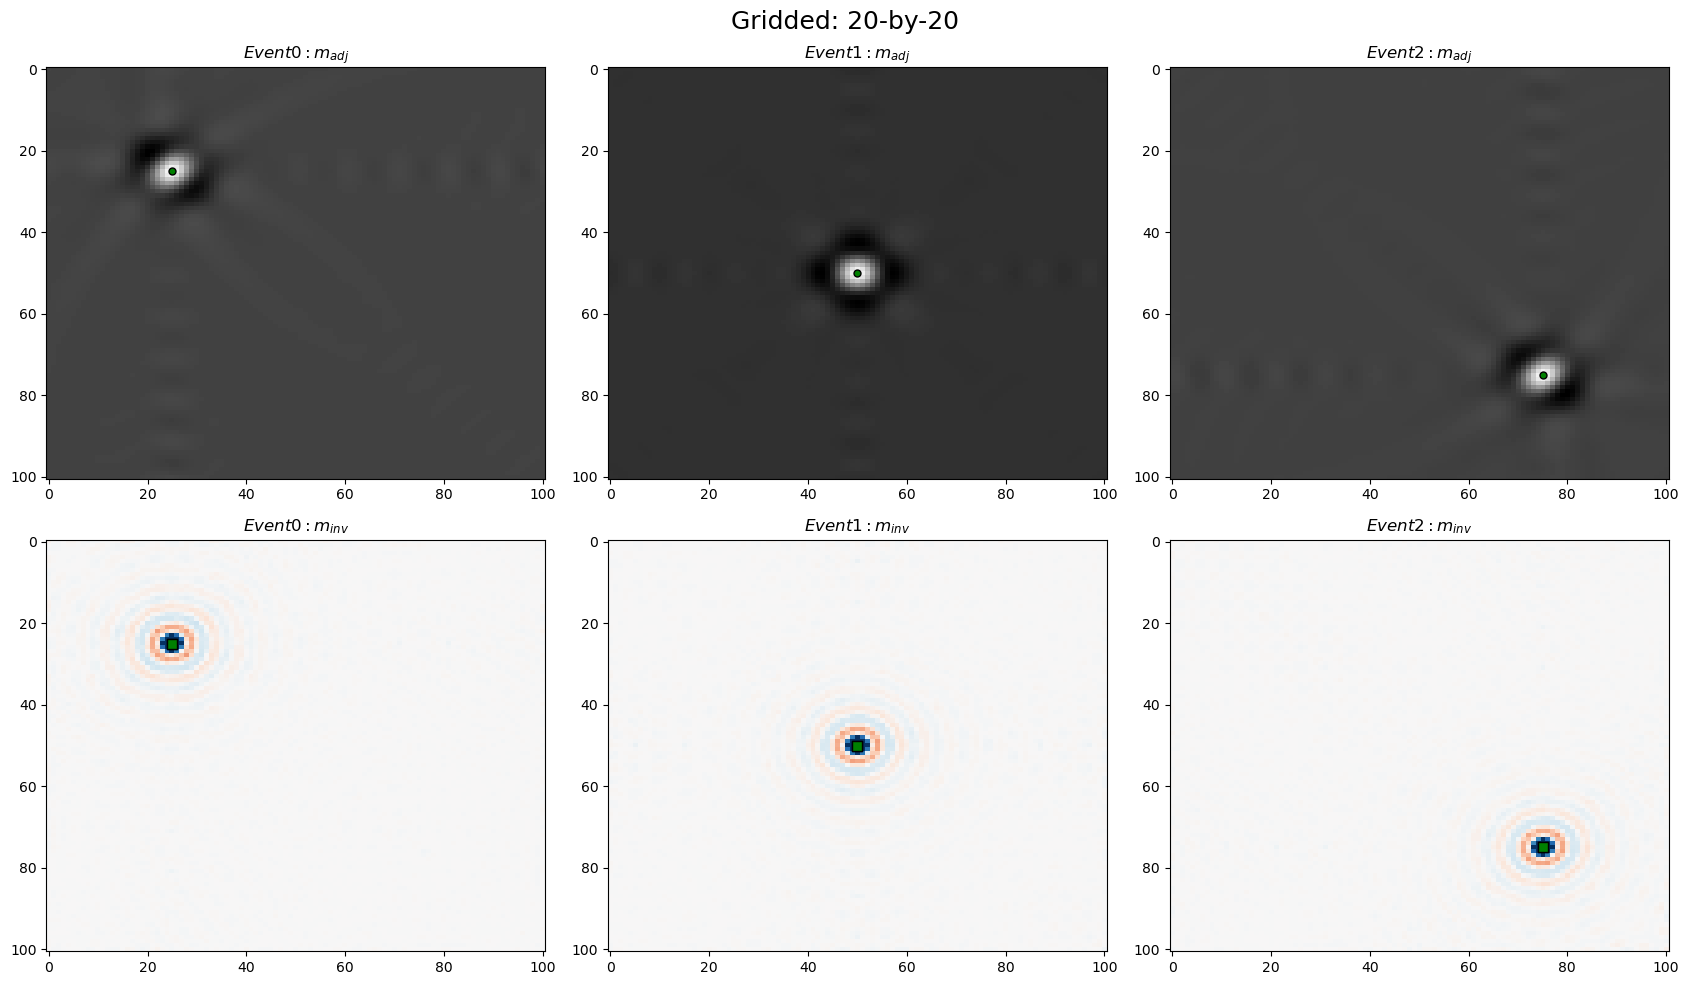

In [13]:
threeevent_invFigure([mig_Ev1, mig_Ev2, mig_Ev3, ],
                     [minv_Ev1, minv_Ev2, minv_Ev3, ],
                     event_dictionary,
                     title_string='Gridded: %s'%rec_string,
                    )

# CROSS ARRAY POINT RECEIVERS

In [14]:
Op_X = Kirchhoff(z, x, t, recs_X[:, :1], recs_X, v0, wav, wavc, mode='analytic', engine='numba')

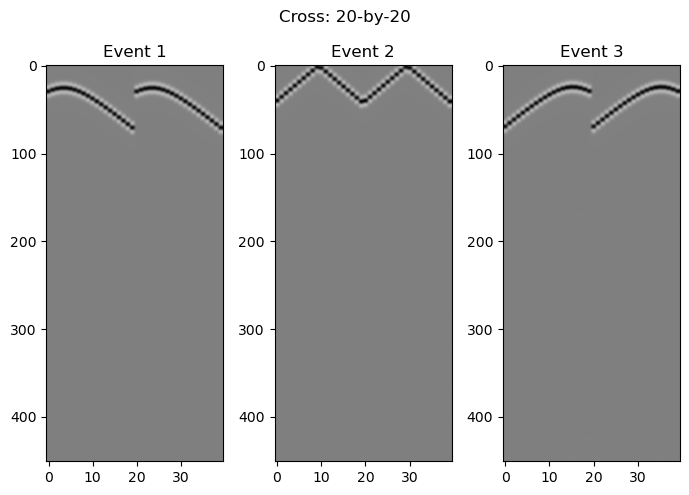

In [15]:
# PERFORM FORWARD (MODEL)
leftEv_data_X = Op_X @ microseismic[0].squeeze()
midEv_data_X = Op_X @ microseismic[1].squeeze()
rightEv_data_X = Op_X @ microseismic[2].squeeze()

fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(leftEv_data_X.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(midEv_data_X.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(rightEv_data_X.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Event 1')
axs[1].set_title('Event 2')
axs[2].set_title('Event 3')
plt.suptitle('Cross: %s'%rec_string)
plt.tight_layout()

In [16]:
# PERFORM ADJOINT (MIGRATE)
mig_Ev1 = Op_X.H @ leftEv_data_X
mig_Ev2 = Op_X.H @ midEv_data_X
mig_Ev3 = Op_X.H @ rightEv_data_X

# PERFORM LSQR
minv_Ev1 = lsqr(Op_X, leftEv_data_X.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev2 = lsqr(Op_X, midEv_data_X.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev3 = lsqr(Op_X, rightEv_data_X.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 18040 rows and 10201 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.187e+01  1.187e+01    1.0e+00  8.2e+00
     1  4.51355e-08   7.205e+00  7.205e+00    6.1e-01  6.0e-01   1.2e+02  1.0e+00
     2  6.19145e-06   4.970e+00  4.970e+00    4.2e-01  4.4e-01   1.7e+02  2.3e+00
     3 -1.06397e-05   3.520e+00  3.520e+00    3.0e-01  2.9e-01   2.1e+02  3.8e+00
     4  2.56723e-04   2.694e+00  2.694e+00    2.3e-01  2.0e-01   2.4e+02  5.3e+00
     5  3.29769e-04   2.255e+00  2.255e+00    1.9e-01  1.7e-01   2.6e+02  6.9e+00
     6  3.01381e-04   1.838e+00  1.838e+00    1.5e-01  1.5e-01   2.8e+02  9.0e+00
     7  2.65583e-04   1.607e+00  1.607e+00    1.4e-01  1.4e-01   3.0e+02  1.1e+01
     8  2.09423e-04   1.435e+00 

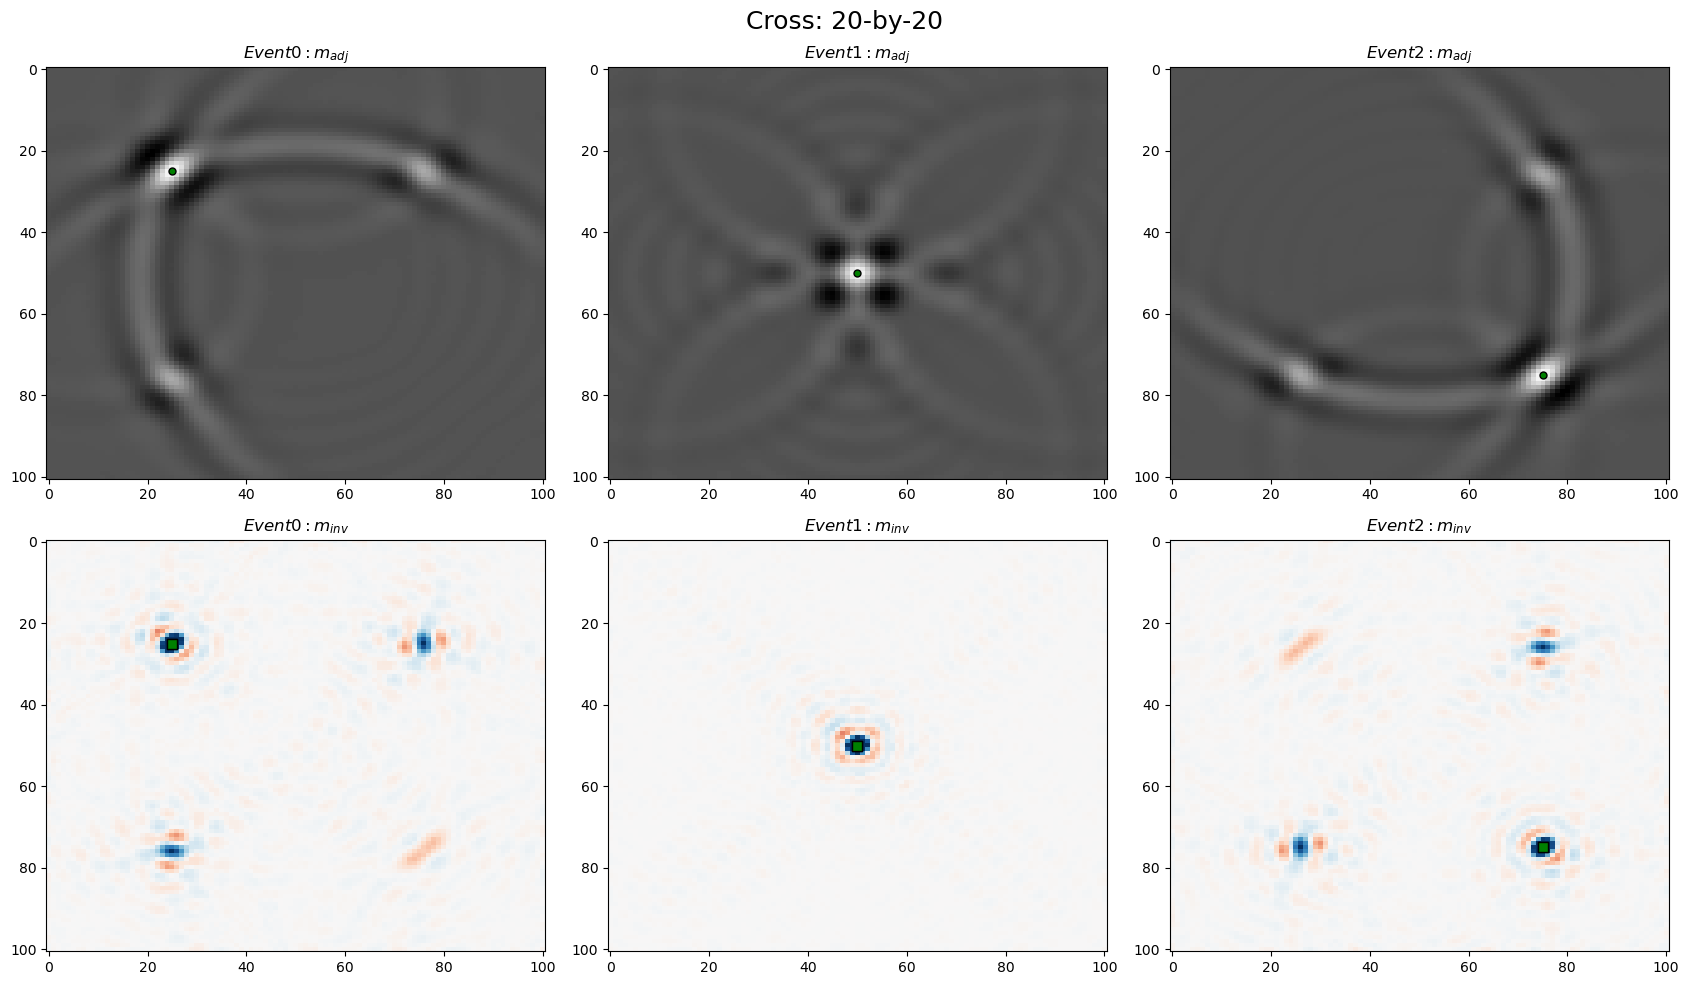

In [17]:
threeevent_invFigure([mig_Ev1, mig_Ev2, mig_Ev3, ],
                     [minv_Ev1, minv_Ev2, minv_Ev3, ],
                     event_dictionary,
                     title_string='Cross: %s'%rec_string,)

# ALL RECEIVERS BUT WITH DATA AVERAGED

In [18]:
def eventgrid_to_lines(eventdata, rx):
    num_ilines = len(rx)
    num_xlines = len(rx[0])

    micro_data_ILXL = eventdata.reshape([num_ilines,
                                         int(eventdata.shape[0]/num_ilines), 
                                         eventdata.shape[1]])
    micro_data_XL = np.sum(micro_data_ILXL,axis=0)
    micro_data_IL = np.sum(micro_data_ILXL,axis=1)

    vline_data = np.tile(micro_data_XL.T, num_ilines).T
    hline_data = np.repeat(micro_data_IL.T, num_xlines, axis=1).T

    lines_data = np.vstack([hline_data,vline_data])
    return lines_data

In [19]:
leftEv_lines_data = eventgrid_to_lines(leftEv_fulldata, rx) 
midEv_lines_data = eventgrid_to_lines(midEv_fulldata, rx) 
rightEv_lines_data = eventgrid_to_lines(rightEv_fulldata, rx) 

lines_recs = np.tile(recs,2)

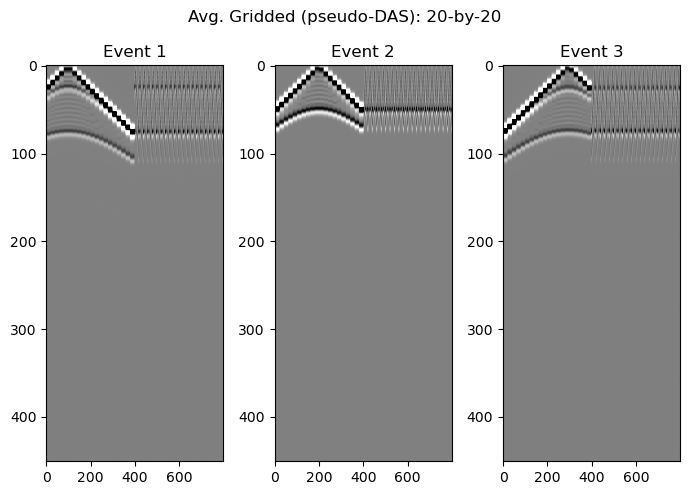

In [20]:
fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(leftEv_lines_data.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(midEv_lines_data.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(rightEv_lines_data.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Event 1')
axs[1].set_title('Event 2')
axs[2].set_title('Event 3')
plt.suptitle('Avg. Gridded (pseudo-DAS): %s'%rec_string)
plt.tight_layout()

In [21]:
Op_lines = Kirchhoff(z, x, t, lines_recs[:, :1], lines_recs, v0, wav, wavc, mode='analytic', engine='numba')

In [22]:
# PERFORM ADJOINT (MIGRATE)
mig_Ev1 = Op_lines.H @ leftEv_lines_data
mig_Ev2 = Op_lines.H @ midEv_lines_data
mig_Ev3 = Op_lines.H @ rightEv_lines_data

# PERFORM LSQR
minv_Ev1 = lsqr(Op_lines, leftEv_lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev2 = lsqr(Op_lines, midEv_lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev3 = lsqr(Op_lines, rightEv_lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 360800 rows and 10201 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.397e+02  2.397e+02    1.0e+00  7.1e-01
     1  3.90652e-04   1.858e+02  1.858e+02    7.8e-01  2.2e-01   2.7e+02  1.0e+00
     2  1.17674e-03   1.792e+02  1.792e+02    7.5e-01  9.7e-02   3.6e+02  2.1e+00
     3  2.18517e-03   1.770e+02  1.770e+02    7.4e-01  4.4e-02   4.4e+02  3.5e+00
     4  1.16610e-03   1.764e+02  1.764e+02    7.4e-01  3.2e-02   5.2e+02  4.8e+00
     5 -1.59850e-03   1.759e+02  1.759e+02    7.3e-01  2.0e-02   6.0e+02  6.8e+00
     6 -3.30274e-03   1.756e+02  1.756e+02    7.3e-01  1.5e-02   6.6e+02  8.6e+00
     7 -4.76554e-03   1.755e+02  1.755e+02    7.3e-01  9.5e-03   7.2e+02  1.1e+01
     8 -5.59688e-03   1.753e+02

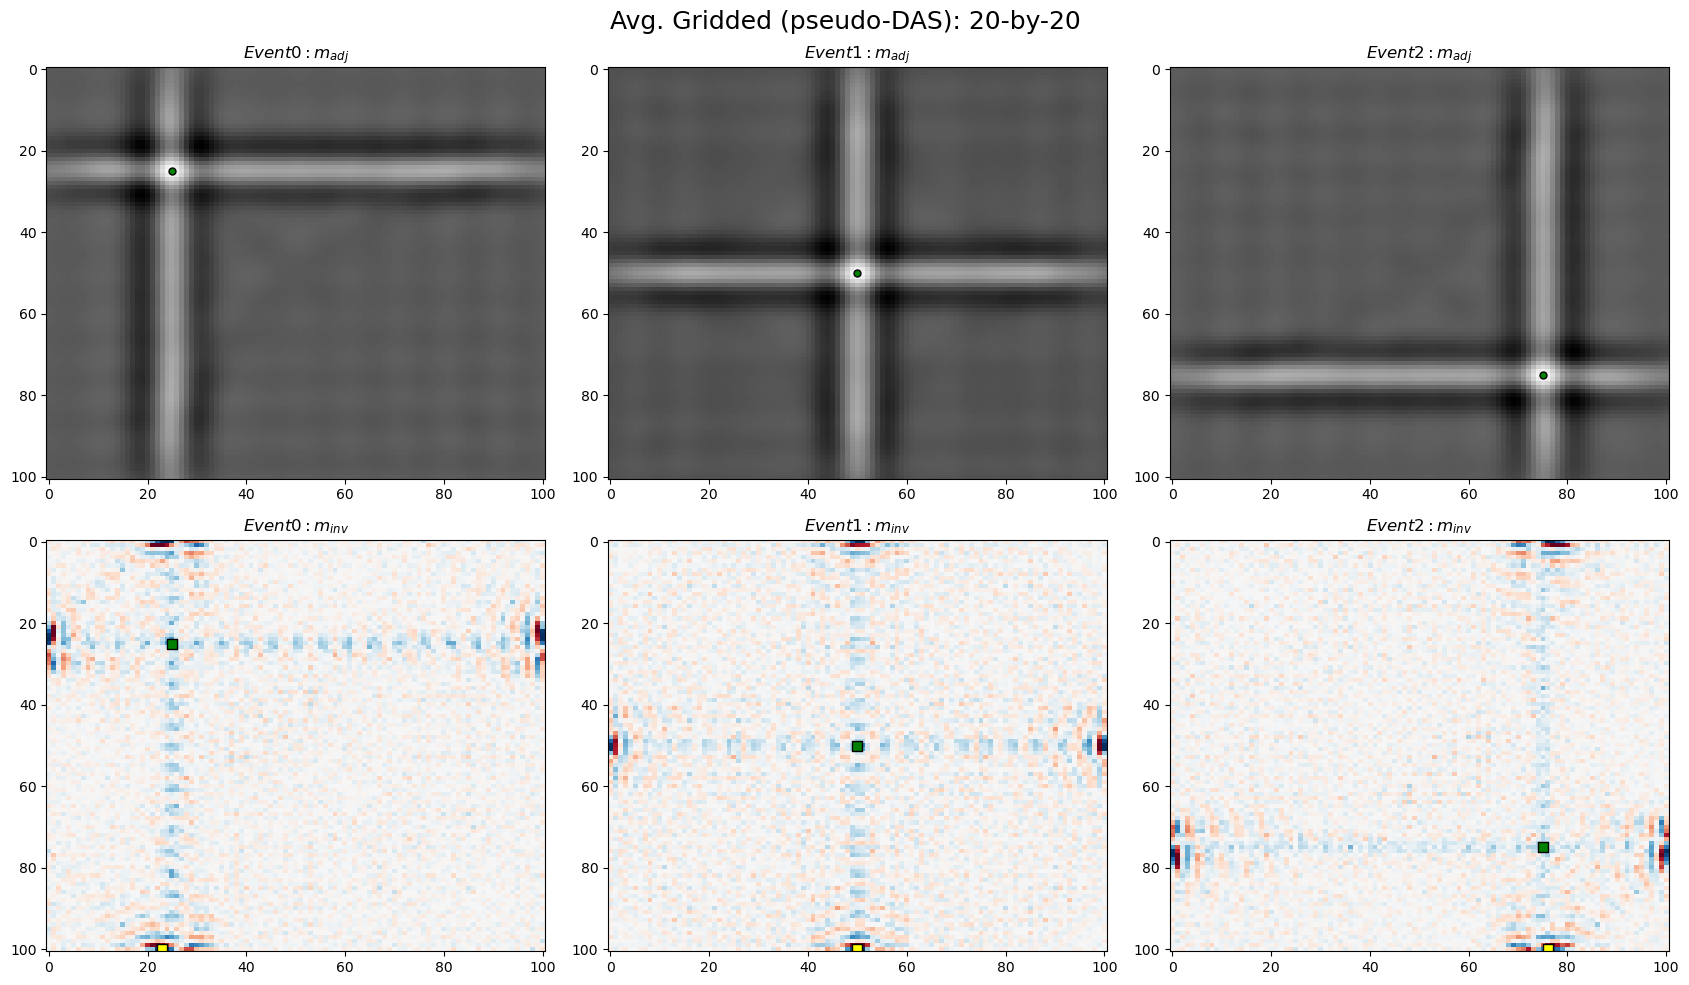

In [23]:
threeevent_invFigure([mig_Ev1, mig_Ev2, mig_Ev3, ],
                     [minv_Ev1, minv_Ev2, minv_Ev3, ],
                     event_dictionary,
                     title_string='Avg. Gridded (pseudo-DAS): %s'%rec_string,)